# 4 Data Preprocessing and Modeling<a id='2_Data_wrangling'></a>

In [20]:
# imports for handling lists
import itertools
# handling warnings
import warnings
# skimage imports
from skimage import data, color, filters, morphology, graph, measure, exposure
from skimage.filters import threshold_otsu, threshold_local, try_all_threshold, sobel, gaussian
from skimage.transform import rotate, rescale, resize
from skimage.feature import canny
from skimage.io import imsave
from skimage.util import img_as_ubyte
# scipy for image
from scipy import ndimage as ndi
# import for file interaction
import os
import io
from pathlib import Path
import cv2
# array and data frame imports
import numpy as np
import pandas as pd
# imports to create the model and data loader
import torch
import torchvision
# import for data augmentation and normalization
from torchvision import transforms
# import for easy metric computation
import torchmetrics
# imports for tarining phase
import pytorch_lightning as pl
# for continuosly storing the weights
from pytorch_lightning.callbacks import ModelCheckpoint
# for enabling logging on tensor board
from pytorch_lightning.loggers import TensorBoardLogger
# helper functions
import helpers as h
# visualization tools
from tqdm.notebook import tqdm # progress bar
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Data Preprocessing

The first step wil be to read the dataset were the labels and image's IDs are stored and check if the latest are unique. In this preprocessing and modeling stage, we will use a different library for interacting with the storage paths, so a couple of more transformations to the tabular data will be necessary, let's explore them.

In [2]:
# loading the dataset saved in 03_EDA
dir_path = r'C:\SPRINGBOARD\retinopathy-detection' # path to repository
labels = pd.read_csv(r'{}\data_processed\labels_sizes_aug.csv'.format(dir_path))

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Image name              1309 non-null   object
 1   Zip File                1309 non-null   object
 2   Image Size              1309 non-null   object
 3   label                   1309 non-null   int64 
 4   Risk of macular edema   1309 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 51.3+ KB


In [4]:
labels.head()

,Image name,Zip File,Image Size,label,Risk of macular edema
0,20051019_38557_0100_PP.tif,Base11.zip,"(1488, 2240, 3)",3,1
1,20051020_43808_0100_PP.tif,Base11.zip,"(1488, 2240, 3)",0,0
2,20051020_43832_0100_PP.tif,Base11.zip,"(1488, 2240, 3)",1,0
3,20051020_43882_0100_PP.tif,Base11.zip,"(1488, 2240, 3)",2,0
4,20051020_43906_0100_PP.tif,Base11.zip,"(1488, 2240, 3)",3,2


The first transformation we will apply to this data frame will be changing the name of the 'Image name' colum for 'image_id'

In [5]:
# renaming image name column
labels.rename(columns={'Image name': 'image_id'}, inplace=True)
labels.head()

,image_id,Zip File,Image Size,label,Risk of macular edema
0,20051019_38557_0100_PP.tif,Base11.zip,"(1488, 2240, 3)",3,1
1,20051020_43808_0100_PP.tif,Base11.zip,"(1488, 2240, 3)",0,0
2,20051020_43832_0100_PP.tif,Base11.zip,"(1488, 2240, 3)",1,0
3,20051020_43882_0100_PP.tif,Base11.zip,"(1488, 2240, 3)",2,0
4,20051020_43906_0100_PP.tif,Base11.zip,"(1488, 2240, 3)",3,2


Now, since we will specify the file extension while handling images, let's just get rid of the '.tif' extension on the image_id values

In [6]:
labels['image_id'] = labels['image_id'].apply(lambda x: x.split('.', 1)[0]) # removing '.tif' string from image_id
labels.head()

,image_id,Zip File,Image Size,label,Risk of macular edema
0,20051019_38557_0100_PP,Base11.zip,"(1488, 2240, 3)",3,1
1,20051020_43808_0100_PP,Base11.zip,"(1488, 2240, 3)",0,0
2,20051020_43832_0100_PP,Base11.zip,"(1488, 2240, 3)",1,0
3,20051020_43882_0100_PP,Base11.zip,"(1488, 2240, 3)",2,0
4,20051020_43906_0100_PP,Base11.zip,"(1488, 2240, 3)",3,2


Good, now it is time to check if all of our images IDs are unique in the data frame (very important for the modeling stage)

In [7]:
# checking the uniqueness of each image ID
labels['image_id'].nunique() == labels.shape[0]

True

Good, there is no need to drop the duplicates in the dataset since all the IDs found are unique. But anyways, let's do it to see no changes in it and for the purpose of how would it be done:

In [8]:
labels.drop_duplicates('image_id', inplace=True)

In [9]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   image_id                1309 non-null   object
 1   Zip File                1309 non-null   object
 2   Image Size              1309 non-null   object
 3   label                   1309 non-null   int64 
 4   Risk of macular edema   1309 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 61.4+ KB


As expected, no changes made on the dataframe.

Now, since our dataframe is ordered by zip files (since it was read in that way: 'Base11.zip' then 'Base12.zip' and so on), we are going to perform this last transformation in it to break that sorting and shuffle the rows to keep the samples as random as possible.

In [10]:
labels = labels.sample(frac=1).reset_index()

In [11]:
labels.head()

,index,image_id,Zip File,Image Size,label,Risk of macular edema
0,674,20060411_61196_0200_PP,Base23.zip,"(960, 1440, 3)",3,1
1,2,20051020_43832_0100_PP,Base11.zip,"(1488, 2240, 3)",1,0
2,1148,20051205_58458_0400_PP,Base34.zip,"(1536, 2304, 3)",0,0
3,630,20060411_58303_0200_PP,Base23.zip,"(960, 1440, 3)",3,0
4,597,20060410_44106_0200_PP,Base22.zip,"(960, 1440, 3)",2,2


In [12]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   index                   1309 non-null   int64 
 1   image_id                1309 non-null   object
 2   Zip File                1309 non-null   object
 3   Image Size              1309 non-null   object
 4   label                   1309 non-null   int64 
 5   Risk of macular edema   1309 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 61.5+ KB


In [13]:
# saving the data frame to a csv file for later use
labels.to_csv(r'{}\data_processed\labels_modeling.csv'.format(dir_path), index=False) # saving the dataframe to path

Now, it is time to load and pre process the image data. Our goal here is preprocess the images and the creating a training and validation dataset with folders of images divided by classes, being:

* --> train_folder
  * --> class_0
  * --> class_1
  * --> class_2
  * --> class_3

And then a folder called:

* --> validation_folder
  * --> class_0
  * --> class_1
  * --> class_2
  * --> class_3
  
Let's see how we can achieve this.

In this cell we are going to create our root and save path by using the Path library, this will allow us to handle the paths in an easier way than we were doing in the previous notebooks.

* ROOT_PATH: where we are going to take our image and tabular data files
* SAVE_PATH: where we are going to save our processed files

In [14]:
ROOT_PATH = Path("C:/SPRINGBOARD/retinopathy-detection/data_processed/data_original/") # take images from
SAVE_PATH = Path("C:/SPRINGBOARD/retinopathy-detection/data_processed/data_model/") # save processed images to

To double check that we in fact have the correct access to the images and integration with the labels at the dataset, let's just plot 9 image examples and show its correcponding label.

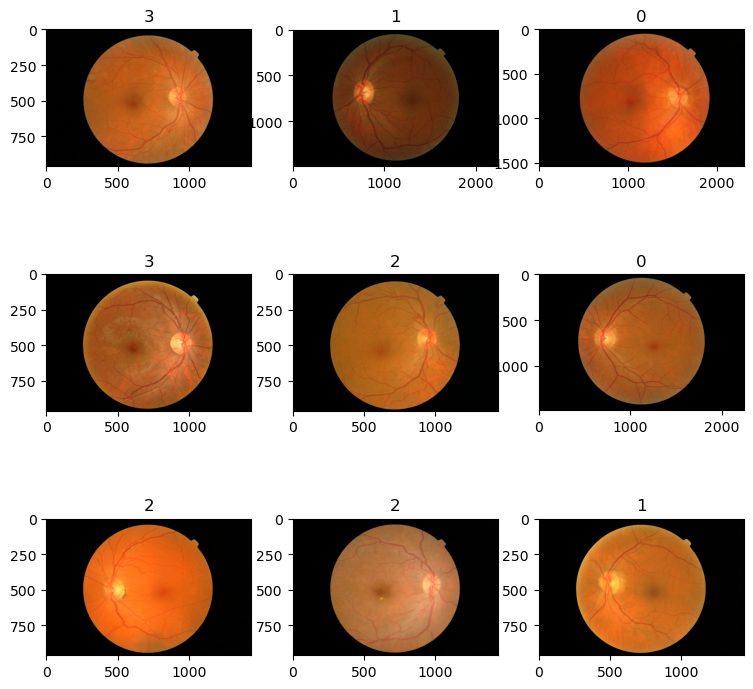

In [15]:
fig, axis = plt.subplots(3, 3, figsize=(9,9))
c = 0
for i in range(3):
    for j in range(3):
        image_id = labels['image_id'].iloc[c]
        tif_path = ROOT_PATH/image_id
        tif_path = tif_path.with_suffix('.tif')
        tif = plt.imread(tif_path)
        
        label = labels['label'].iloc[c]
        
        axis[i][j].imshow(tif, cmap='gray')
        axis[i][j].set_title(label)
        c += 1

Noe it is time to preprocessing and loading our data. In this section we will:

1. Look on our image_id
2. Standarize and resize images
3. Split the train and validation set (80 - 20)
4. Store them in the corresponding directory according to their labels

In [16]:
sums, sums_squared = 0, 0

# for loop over image_id's to split the train (80%) and test set (20%)
for c, image_id in enumerate(tqdm(labels['image_id'])):
    image_id = labels['image_id'].iloc[c]
    tif_path = ROOT_PATH/image_id
    tif_path = tif_path.with_suffix('.tif')
    tif = plt.imread(tif_path) / 255
    
    # to 'help' the deep learning architecture, we will reshape the images to 244x244
    # this will allow to decrease our computational time for the modeling
    # saving it as float16 to occupy less space in memory by saving it an npy file (numpy array file)
    tif_array = cv2.resize(tif, (244, 244)).astype(np.float16) 
    label = labels['label'].iloc[c]
    
    # deciding in which folder to save the image according to the label
    train_or_val = "train" if c < 1047 else "val"
    
    current_save_path = SAVE_PATH/train_or_val/str(label) # save to this directory with specific label
    current_save_path.mkdir(parents=True, exist_ok=True) # in case the directory is not existent or existent
    np.save(current_save_path/image_id, tif_array) # saving the preprocessed tif array
    
    # computing the normalizer: takes the number of pixels in each image
    normalizer = 224*224 # number of pixels
    # normalizing images
    if train_or_val == "train":
        sums += np.sum(tif_array) / normalizer
        sums_squared += (tif_array ** 2).sum() / normalizer

  0%|          | 0/1309 [00:00<?, ?it/s]

The next step is to convert our sums and sum_squared variables into mean and standard deviation respectively. This step is taken to compute the mean and stamdard deviation for normalization, the following equations are used for that:

$$mu = \frac{sums}{(N)}$$

$$sigma = \sqrt{\frac{sumssquared}{N} - mu^2}$$

Where 

* N = number of images in our database

In [17]:
mean = sums / 1309
std = np.sqrt((sums_squared / 1309) - mean**2)

In [18]:
# let's see the values
display('Mean: ', mean)
display('Std: ', std)

'Mean: '

0.47862521632029437

'Std: '

0.16931809783456828

These values will be used next for normalizing our dataset

## Data Loading

For loading the data, we can leverage our labeled dataset folders by using torch vision by passing only the root directory and returns the dataset with access to all data within the sub folders of the roots directory. This data returns the data stored in the subdirectories, together with the name of the corresponding subdirectory as the label.

The way to do it will be to first define a loader function, which defines how the unique files should be loaded and pass a list of the file extensions (.NPY) we want to load to the dataset folder of the class.

Afterwards, we need to pass the transformation sequence for data augmentation and normalization. Let's jump right into it!

In [21]:
# defining loade function
def load_file(path): 
    return np.load(path).astype(np.float32) # load the np array and convert it to float 32

Next, we need to define the list of transformations that we will be doing in both our training and validation data:

1. Convert the np array to a torch tensor
2. Normalize our images using our mean and std computed previously
3. Data augmentation pipeline
    * 3.1 Random rotation between -5 and 5
    * 3.2 Random translations of at max five percent
    * 3.3 Scale from 0.9 to 1.1 for randomly scaling the images
4. Random rsized crops (croping a random portion of the image and resize the crop)

In [30]:
# list of transformations that need to be done in the data using 'transforms.Compose()' function
train_transforms = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std),
                                    transforms.RandomAffine(degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
])

# for validation data, we are only applying two of the transformations we did above
val_transforms = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)
])

The next step is to create our train and validation datasets 

In [31]:
# creating train dataset
train_dataset = torchvision.datasets.DatasetFolder("C:/SPRINGBOARD/retinopathy-detection/data_processed/data_model/train/", 
                                                   loader=load_file,
                                                  extensions="npy",
                                                  transform=train_transforms)
# creating val dataset
val_dataset = torchvision.datasets.DatasetFolder("C:/SPRINGBOARD/retinopathy-detection/data_processed/data_model/val/", 
                                                   loader=load_file,
                                                  extensions="npy",
                                                  transform=val_transforms)

Let's see some of the transformed images these pipelines return

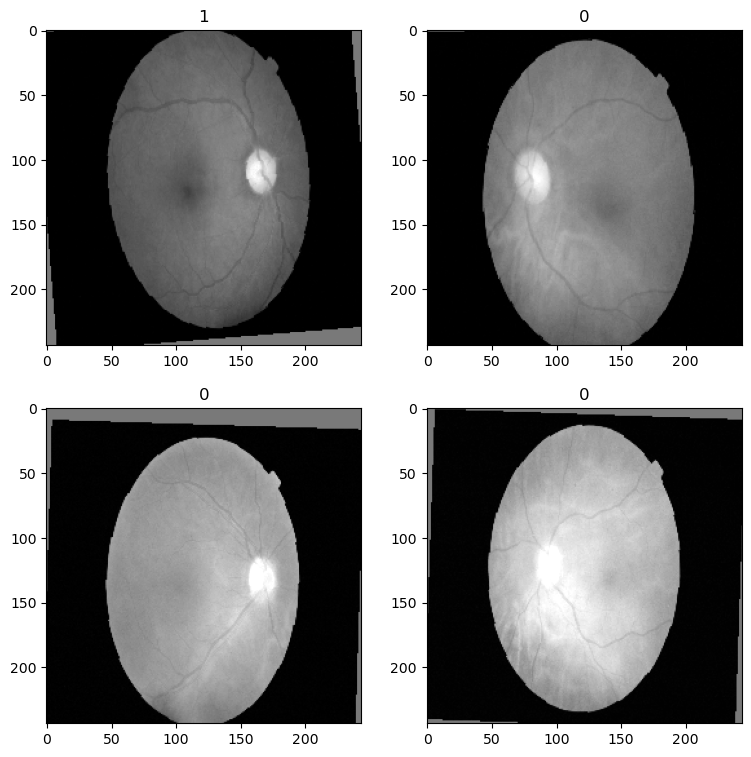

In [38]:
# visualization
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 1047) # returns an index between 0 and 1047
        eye, label = train_dataset[random_index]
        axis[i][j].imshow(eye[0], cmap='gray')
        axis[i][j].set_title(label)

Next, we are going to create our train and validation data loaders by defining a batch size and number of workers that our hardware can handle

In [40]:
batch_size = 64
num_workers = 4
# creating the train loader with shuffling to get a variety of classes in the training stage
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
# creating the val loader without shuffling to get a deterministic evaluation
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In this step, we will confirm the class balance once more so we can have a sense of the number of images belonging to each label after our manually augmentation done in 03_EDA and the augmentation made in this stage

In [46]:
np.unique(train_dataset.targets, return_counts=True) # to get the distribution of the labels

(array([0, 1, 2, 3]), array([529, 250, 237, 245], dtype=int64))

As expected, class 1, 2 and 3 are well balanced. However there are much more class 0 which makes our dataset imbalanced. Which is something we could address by:

1. Doing nothing about it
2. Using a weighted loss function (higher loss to a prediction)
3. Oversampling (keep the same sampling size of all classes)

In this case, let's try to use a weighted sampling of around 2 since we have almost two times class 0 images than the other classes (step that is done at the modeling stage).

## 4.n Summary<a id='2.7_Summary'></a>